# Code to analyse usage BCD vs. CROS

1 March 2021 Guido Cattani

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mannwhitneyu
from scipy.stats import wilcoxon as wilcoxon
from scipy.stats import shapiro as shapiro

In [2]:
# read usage BCD vs. CROS
def read_usage():
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Headband/Usage_BCD_CROS.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, header=0, nrows=85)
    df = df.drop(['Unnamed: 0',], axis=1)
    df = df.fillna(pd.NA)
    return df

In [3]:
df = read_usage()
df_usage = df.drop(columns='Study_ID') # drop first column
df_usage = df_usage.dropna(axis='index')
type_device = df_usage.pop('Device')
df_usage = df_usage.astype('float64')    # change numeric data to type float, because of objects
df_usage.insert(0, 'Device', type_device)
df_usage

,Device,Average_use_BCD,Average_use_CROS
2,BP110,0.4,4.9
3,BP110,1.0,2.0
4,BP110,1.4,2.3
6,BP110,3.2,4.4
7,BP110,0.7,13.1
...,...,...,...
80,BAHA5P,3.9,10.5
81,BAHA5P,0.6,13.9
82,BAHA5P,0.3,4.8
83,BAHA5P,1.1,12.0


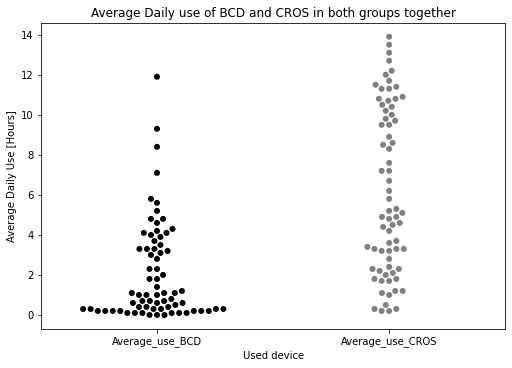

In [4]:
# make a figure to plot the usage
ttl = 'Average Daily use of BCD and CROS in both groups together'

pp= df_usage.drop(columns='Device') # drop first column with Device info
tp = pd.melt(pp, var_name = 'Used device', value_name = 'Average Daily Use [Hours]') 

fig, ax = plt.subplots(constrained_layout=True)

fig.set_figheight(5)
fig.set_figwidth(7)

ax = sns.swarmplot(data = tp, x = 'Used device', y = 'Average Daily Use [Hours]', 
                   size=6, palette={'grey', 'black'})

ax.set_title(ttl)
#plt.legend(bbox_to_anchor=(0.15, 0.25), fontsize='large')

# save figure to file
plt.savefig('/media/guido/LACIE/Cingle_Guido/Project_band/Analysis_results/usage_BCD_CROS_pool.tiff', 
           transparent=False, dpi=500, bbox_inches="tight")

plt.show()

In [5]:
# group data by device type and perform calculation of quantiles 10, 50, 90
#dvc_usage = df_usage.groupby('Device')
quantiles = [0.10, 0.50, 0.90]
q = pp.quantile(q=quantiles)
q

,Average_use_BCD,Average_use_CROS
0.1,0.1,1.2
0.5,1.0,5.1
0.9,4.8,11.5


In [6]:
u_bcd = (pp.iloc[:,0]).T.to_numpy()
u_cros = (pp.iloc[:,1]).T.to_numpy()
u_diff = u_cros - u_bcd
wd= wilcoxon(u_diff)
wd

WilcoxonResult(statistic=248.5, pvalue=3.656863027556037e-09)

In [7]:
usage_diff = df_usage.iloc[:,2] - df_usage.iloc[:,1]
df_usage.insert(3, 'Diff. usage CROS-BCD', usage_diff)
df_usage

,Device,Average_use_BCD,Average_use_CROS,Diff. usage CROS-BCD
2,BP110,0.4,4.9,4.5
3,BP110,1.0,2.0,1.0
4,BP110,1.4,2.3,0.9
6,BP110,3.2,4.4,1.2
7,BP110,0.7,13.1,12.4
...,...,...,...,...
80,BAHA5P,3.9,10.5,6.6
81,BAHA5P,0.6,13.9,13.3
82,BAHA5P,0.3,4.8,4.5
83,BAHA5P,1.1,12.0,10.9


In [8]:
# group data by device type and perform calculation of quantiles 10, 50, 90
dvc_usage = df_usage.groupby('Device')
quantiles = [0.10, 0.50, 0.90]
q = dvc_usage.quantile(q=quantiles)
q

Average_use_BCD  Average_use_CROS  Diff. usage CROS-BCD
Device                                                             
BAHA5P 0.1              0.1              2.19                 -0.85
       0.5              1.5              5.75                  4.75
       0.9              4.9             11.43                 10.36
BP110  0.1              0.1              1.00                 -0.50
       0.5              0.7              4.90                  3.10
       0.9              4.8             11.50                 11.20

In [9]:
# rearranging the datafame with quantiles
q= q.round(decimals=1)
q.reset_index(drop=True, inplace=True)
diq = {0:'BAHA5P P10', 1:'BAHA5P P50', 2:'BAHA5P P90', 
      3:'BP110 P10', 4:'BP110 P50', 5:'BP110 P90'} 

q = q.rename(index=diq)
q

,Average_use_BCD,Average_use_CROS,Diff. usage CROS-BCD
BAHA5P P10,0.1,2.2,-0.8
BAHA5P P50,1.5,5.8,4.8
BAHA5P P90,4.9,11.4,10.4
BP110 P10,0.1,1.0,-0.5
BP110 P50,0.7,4.9,3.1
BP110 P90,4.8,11.5,11.2


In [10]:
# select BP110 data and convert the Pandas Dataframe to numpy array
is_bp110 =  df_usage['Device']=='BP110'
usage_bp110 = df_usage[is_bp110]
dvc1 = usage_bp110.pop('Device')
bp110 = usage_bp110.T.to_numpy()

usage_bp110.shape

(41, 3)

In [11]:
# select BAHA5P data and convert the Pandas Dataframe to numpy array
is_baha5p =  df_usage['Device']=='BAHA5P'
usage_baha5p = df_usage[is_baha5p]
dvc2 = usage_baha5p.pop('Device')
bh5 = usage_baha5p.T.to_numpy()

usage_baha5p.shape

(30, 3)

In [12]:
# check normality AC thresholds group BAHA5P & BP110 with Shapiro-Wilk test

shp = dict()
f = ['Average_use_BCD', 'Average_use_CROS', 'Diff. usage CROS-BCD']

for i in range(3):
    a = usage_baha5p.iloc[:, i]
    b = usage_bp110.iloc[:, i]
    shapiro_stat_bh5, pVal_bh5 = shapiro(a) # bh5 scipy.stats Shapiro-Wilk test test
    shapiro_stat_bp110, pVal_bp110 = shapiro(b) # bp110 scipy.stats Shapiro-Wilk test test
    bh5_is_normal = False if pVal_bh5 < 0.05 else True
    bp110_is_normal = False if pVal_bp110 < 0.05 else True
    both_is_normal = True if bh5_is_normal and bp110_is_normal else False
    st = {f[i]: [shapiro_stat_bh5, pVal_bh5, bh5_is_normal, shapiro_stat_bp110, pVal_bp110, bp110_is_normal, both_is_normal]}
    shp.update(st)

shapiro_test = pd.DataFrame.from_dict(shp)
dish =  {0: 'Shapiro test statistic BH5', 1: 'p-value BH5', 2: 'normally distributed in BH5', 3: 'Shapiro test statistic BP110', 
         4: 'p-value BP110', 5: 'normally distributed in BP110', 6: 'normally distributed in both groups'}
shapiro_test = shapiro_test.rename(index=dish)
shapiro_test

,Average_use_BCD,Average_use_CROS,Diff. usage CROS-BCD
Shapiro test statistic BH5,0.827814,0.91128,0.986445
p-value BH5,0.00022,0.016031,0.959155
normally distributed in BH5,False,False,True
Shapiro test statistic BP110,0.766666,0.921719,0.957592
p-value BP110,0.000001,0.007745,0.129485
normally distributed in BP110,False,False,True
normally distributed in both groups,False,False,True


In [13]:
# compare distribution of Usage between groups BP110 & BAHA5P with Mann Whitney U test
d1 = dict()
d2 = dict()
for i in range(0, 3):
    (stat, pvalue) = mannwhitneyu(bp110[i], bh5[i], use_continuity=False, alternative='two-sided')
    d1.update({i : stat})
    d2.update({i : pvalue})

In [14]:
mwu = pd.DataFrame.from_dict([d1, d2])
rws = {0: 'Mann-Whitney U statistic', 1: 'p-value (two-sided)'}
clmns = {0 : 'Average_use_BCD', 1 : 'Average_use_CROS', 2 : 'Diff. usage CROS-BCD'}
mwu.rename(index = rws, columns = clmns, inplace = True)
mwu = mwu.round(decimals=4)
mwu

,Average_use_BCD,Average_use_CROS,Diff. usage CROS-BCD
Mann-Whitney U statistic,525.5000,502.5000,565.0000
p-value (two-sided),0.2969,0.1903,0.5605


In [15]:
analysis_output = pd.concat([q, mwu])
analysis_output = analysis_output.round(decimals=3)
analysis_output

,Average_use_BCD,Average_use_CROS,Diff. usage CROS-BCD
BAHA5P P10,0.100,2.20,-0.80
BAHA5P P50,1.500,5.80,4.80
BAHA5P P90,4.900,11.40,10.40
BP110 P10,0.100,1.00,-0.50
BP110 P50,0.700,4.90,3.10
BP110 P90,4.800,11.50,11.20
Mann-Whitney U statistic,525.500,502.50,565.00
p-value (two-sided),0.297,0.19,0.56


In [16]:
# write to xlsx file
analysis_output.to_excel("/media/guido/LACIE/Cingle_Guido/Project_band/Analysis_results/analysis_usage_BCD_vs_CROS.xlsx",
                         sheet_name='analysis_usage_BCD_vs_CROS')  

In [17]:
# test difference usage in group BAHA5P
w_bh5 = wilcoxon(bh5[2]) 
w_bh5 #baha5p vs CROS

WilcoxonResult(statistic=38.0, pvalue=6.319756764397932e-05)

In [18]:
# test difference usage in group BP110
w_bp110 = wilcoxon(bp110[2])
w_bp110 #bp110 vs CROS

WilcoxonResult(statistic=94.0, pvalue=1.2966432052269752e-05)

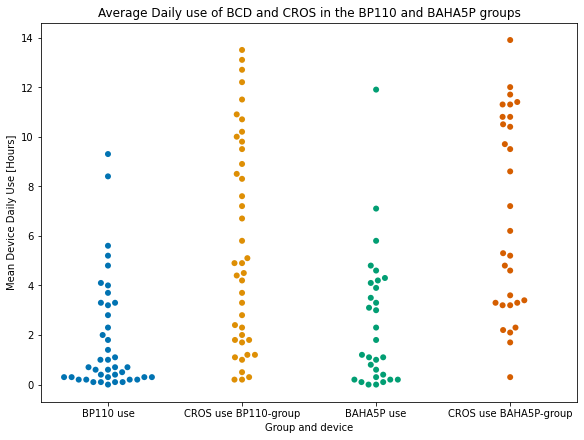

In [19]:
# make a figure to plot the usage of the 2 groups separetely
ttl = 'Average Daily use of BCD and CROS in the BP110 and BAHA5P groups'

d = {'BP110 use' : bp110[0], 'CROS use BP110-group' : bp110[1], 'BAHA5P use' : bh5[0], 
     'CROS use BAHA5P-group' : bh5[1]} 

pp = pd.DataFrame.from_dict(d, orient='index')
pp = pp.transpose()
tp = pd.melt(pp, var_name = 'Group and device', value_name = 'Mean Device Daily Use [Hours]') 

fig, ax = plt.subplots(constrained_layout=True)

fig.set_figheight(6)
fig.set_figwidth(8)

ax = sns.swarmplot(data = tp, x = 'Group and device', y = 'Mean Device Daily Use [Hours]', 
                   size=6, palette='colorblind')

ax.set_title(ttl)
#plt.legend(bbox_to_anchor=(0.15, 0.25), fontsize='large')

# save figure to file
plt.savefig('/media/guido/LACIE/Cingle_Guido/Project_band/Analysis_results/usage_BCD_vs_CROS.tiff', 
           transparent=False, dpi=500, bbox_inches="tight")

plt.show()

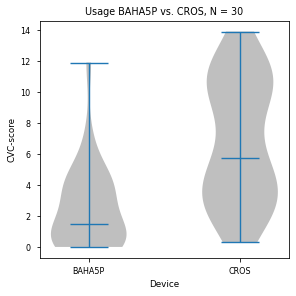

In [20]:
# make a violin plot about Usage BAHA5P vs. CROS

plt.style.use('seaborn-paper')
plt.rcParams['axes.facecolor'] = 'white'

fig, ax = plt.subplots(constrained_layout=True)

fig.set_figheight(4)
fig.set_figwidth(4)

ax.set(xlabel='Device', ylabel='CVC-score',
       title='Usage BAHA5P vs. CROS, N = 30')

ax.set_xticks([1, 2])
ax.set_xticklabels(['BAHA5P', 'CROS'])

violin = ax.violinplot(dataset = [bh5[0], bh5[1]], showmedians=True)

for viol in violin['bodies']:
    viol.set_facecolor('grey')
    viol.set_alpha(0.5)

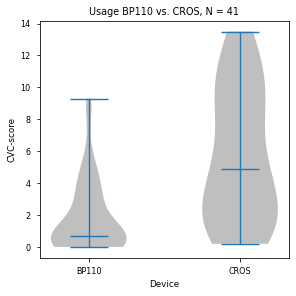

In [21]:
# make a violin plot about Usage BP110 vs. CROS

plt.style.use('seaborn-paper')
plt.rcParams['axes.facecolor'] = 'white'

fig, ax = plt.subplots(constrained_layout=True)

fig.set_figheight(4)
fig.set_figwidth(4)

ax.set(xlabel='Device', ylabel='CVC-score',
       title='Usage BP110 vs. CROS, N = 41')

ax.set_xticks([1, 2])
ax.set_xticklabels(['BP110', 'CROS'])

violin = ax.violinplot(dataset = [bp110[0], bp110[1]], showmedians=True)

for viol in violin['bodies']:
    viol.set_facecolor('grey')
    viol.set_alpha(0.5)

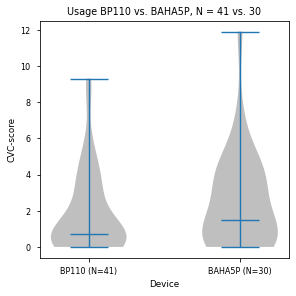

In [22]:
# make a violin plot about Usage BP110 vs. BAHA5P

plt.style.use('seaborn-paper')
plt.rcParams['axes.facecolor'] = 'white'

fig, ax = plt.subplots(constrained_layout=True)

fig.set_figheight(4)
fig.set_figwidth(4)

ax.set(xlabel='Device', ylabel='CVC-score',
       title='Usage BP110 vs. BAHA5P, N = 41 vs. 30')

ax.set_xticks([1, 2])
ax.set_xticklabels(['BP110 (N=41)', 'BAHA5P (N=30)'])

violin = ax.violinplot(dataset = [bp110[0], bh5[0]], showmedians=True)

for viol in violin['bodies']:
    viol.set_facecolor('grey')
    viol.set_alpha(0.5)